In [1]:
#%pip install seaborn
#%pip install torchsummary
#%pip install tqdm

In [2]:
import fnmatch
import gc
import math
import os
import pathlib
import random
import sys
import time

import intel_extension_for_pytorch as ipex
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import psutil
import seaborn as sns
import torch
import torch.nn as nn
import torchvision.models as models
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
from torchsummary import summary
from tqdm import tqdm

sns.set_theme(style="whitegrid", palette="husl")

2022-07-01 18:15:24,563 - numexpr.utils - INFO - Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2022-07-01 18:15:24,564 - numexpr.utils - INFO - NumExpr defaulting to 8 threads.


In [3]:
print(f"torch version: {torch.__version__}")
print(f"ipex version: {ipex.__version__}")

torch version: 1.11.0
ipex version: 1.11.200


In [4]:
def select_device(val: str = ""):
    """select compute device."""
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    if val == "cpu":
        device = val
    print(f"device selected: {device}")
    return device


def seed_everything(device, seed: int = 4242):
    """set all random seeds using `seed`"""
    print(f"seed set to: {seed}")
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    if device != "cpu":
        torch.cuda.manual_seed_all(seed)


def set_env_vars() -> int:
    """set openMP and torch params"""
    num_physical_cores = psutil.cpu_count(logical=False)
    print(f"setting omp num threads: {num_physical_cores}")
    os.environ["OMP_NUM_THREADS"] = str(num_physical_cores)
    os.environ["KMP_AFFINITY"] = "granularity=fine,compact,1,0"
    os.environ["KMP_BLOCKTIME"] = "1"
    torch.set_num_interop_threads(2)
    torch.set_num_threads(num_physical_cores)
    return num_physical_cores


device = select_device("cpu")
seed_everything(device, 9342)
num_physical_cores = set_env_vars()


device selected: cpu
seed set to: 9342
setting omp num threads: 10


In [5]:
# training, validation & test dataset transforms, test and validation transforms are the same
imagenet_stats = [[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]]
img_transforms = {
    "train": transforms.Compose(
        [
            transforms.RandomApply(
                [transforms.GaussianBlur(kernel_size=(1, 3), sigma=(1, 3))], p=0.2
            ),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(180),
            transforms.ToTensor(),
            transforms.Normalize(*imagenet_stats),
        ]
    ),
    "valid": transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize(*imagenet_stats)]
    ),
}

In [6]:
# create dataset for Training and Validation
num_physical_cores = psutil.cpu_count(logical=False)
data_dir = pathlib.Path("./data/ThreeClassManualRemove0s")
TRAIN_DIR = data_dir / "train"
VALID_DIR = data_dir / "val"

# no augmentation for test and validation data
train_data = datasets.ImageFolder(TRAIN_DIR, transform=img_transforms["train"])
test_data = datasets.ImageFolder(  
    TRAIN_DIR, transform=img_transforms["valid"]
)
valid_data = datasets.ImageFolder(VALID_DIR, transform=img_transforms["valid"])

In [7]:
def data_distribution(dataset=train_data, path: str = TRAIN_DIR) -> dict:
    """return dict of data distribtion of each class."""
    cls_count = dict.fromkeys(dataset.class_to_idx, 0)
    for cls in cls_count.keys():
        cls_count[cls] = len(fnmatch.filter(os.listdir(f"{path}/{cls}"), "*.png"))
    return cls_count


def plot_data_distribution(data_dist: dict, title: str = ""):
    """plot data distribution"""
    cls, count = list(data_dist.keys()), list(data_dist.values())
    p = sns.barplot(x=cls, y=count)
    p.set_title(title)


train data dist: {'0': 1075, '1': 1207, '2': 1360}


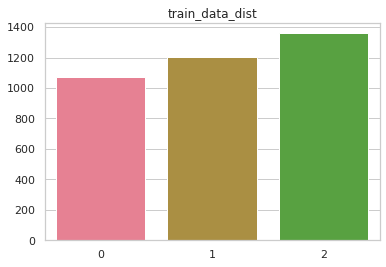

In [8]:
train_data_dist = data_distribution(train_data, path=TRAIN_DIR)
plot_data_distribution(train_data_dist, "train_data_dist")
print(f"train data dist: {train_data_dist}")

valid data dist: {'0': 269, '1': 286, '2': 341}


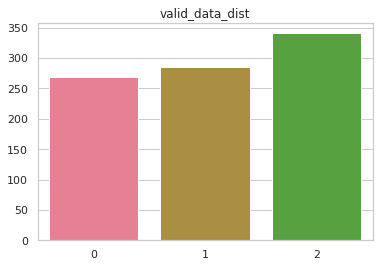

In [9]:
valid_data_dist = data_distribution(valid_data, path=VALID_DIR)
plot_data_distribution(valid_data_dist, "valid_data_dist")
print(f"valid data dist: {valid_data_dist}")

In [10]:
# create train and test dataset from train_data
dataset_len = len(train_data.targets)
data_idx = [x for x in range(dataset_len)]
train_idx, test_idx = train_test_split(
    data_idx, test_size=0.3, stratify=train_data.targets, shuffle=True
)
train_data = torch.utils.data.Subset(train_data, train_idx)
test_data = torch.utils.data.Subset(test_data, test_idx)
print(f" train, valid, test sizes: {len(train_data), len(test_data), len(valid_data)}")

 train, valid, test sizes: (2549, 1093, 896)


In [11]:
# create data loaders
batch_size = 64
num_workers = 1 if device == "cpu" else math.ceil(num_physical_cores * 0.4)
pin_memory = False if device == "cpu" else True

train_dataloader = DataLoader(
    train_data,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=pin_memory,
)
test_dataloader = DataLoader(
    test_data, 
    batch_size=batch_size, 
    num_workers=num_workers, 
    pin_memory=pin_memory
)
valid_dataloader = DataLoader(
    valid_data, 
    batch_size=batch_size, 
    num_workers=num_workers, 
    pin_memory=pin_memory
)

print(f"num wokers used to load dataset: {num_workers}")
print(f"batch size: {batch_size}")


num wokers used to load dataset: 1
batch size: 64


In [12]:
def _denormalize(images, imagenet_stats):
    """de normalize dataset using imagenet std and mean to show images"""
    mean = torch.tensor(imagenet_stats[0]).reshape(1, 3, 1, 1)
    std = torch.tensor(imagenet_stats[1]).reshape(1, 3, 1, 1)
    return images * std + mean


def show_data(dataloader, imagenet_stats=imagenet_stats, num_data=4, figsize=(10,6)):
    """show `num_data` of images and labels from dataloader."""
    batch = next(iter(dataloader))  # batch of with images, batch of labels
    imgs, labels = (
        batch[0][:num_data],
        batch[1][:num_data].tolist(),
    )  # get num_data of images, labels
    plt.style.use("dark_background")
    _, axes = plt.subplots(1, num_data, figsize=figsize)
    for n in range(num_data):
        axes[n].set_title(labels[n])
        imgs[n] = _denormalize(imgs[n], imagenet_stats)
        axes[n].imshow(torch.clamp(imgs[n], 0, 1).permute(1, 2, 0))


training data


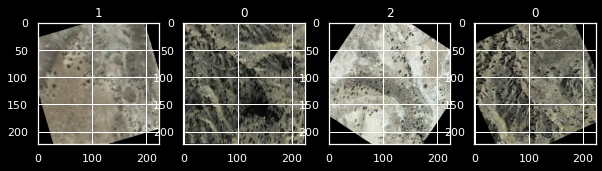

In [13]:
print("training data")
show_data(train_dataloader)

test data


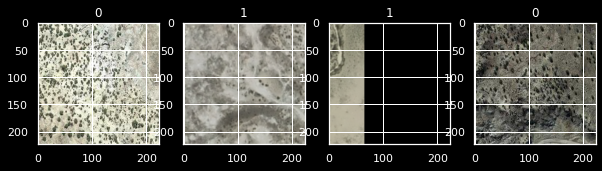

In [14]:
print("test data")
show_data(test_dataloader)

validation data


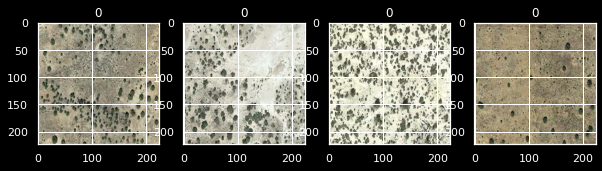

In [15]:
print("validation data")
show_data(valid_dataloader)

In [16]:
class DinosourBoneFinder(nn.Module):
    """
    A model to classify arial images that could potential have Jurassic fossils.
    We are using a backbone pretrained Resnet model and images given to model are
    classified into one of 3 classes.
    0 - no bone
    1 -
    2 -
    """

    def __init__(self, backbone=18, simple=False):
        super(DinosourBoneFinder, self).__init__()
        backbones = {
            18: models.resnet18,
            34: models.resnet34,
            50: models.resnet50,
            101: models.resnet101,
        }
        self.network = backbones[backbone](pretrained=True)
        for m, p in zip(self.network.modules(), self.network.parameters()):
            if isinstance(m, nn.BatchNorm2d):
                p.requires_grad = False
        if simple:
            self.network.fc = nn.Linear(self.network.fc.in_features, 3)
        else:
            self.network.fc = nn.Sequential(
                nn.Linear(self.network.fc.in_features, 256),
                nn.ReLU(),
                nn.Dropout(0.6),
                nn.Linear(256, 3),
            )

    def forward(self, x_batch):
        return self.network(x_batch)

    def get_summary(self, device):
        """print summary of the model."""
        summary(self, input_size=(3, 224, 224), device=device)


In [17]:
class Metrics:
    """class that holds logic for calculating accuracy and printing it"""

    def __init__(self):
        self.acc = {"train": [], "val": []}
        self.loss = {"train": [], "val": []}

    @staticmethod
    @torch.no_grad()
    def accuracy(yhat, labels, debug):
        """accuracy of a batch"""
        yhat = torch.log_softmax(yhat, dim=1)  # softmax of logit output
        yhat = yhat.max(1)[1]  # get index of max values
        if debug:
            print(f"outputs: {yhat}")
            print(f"labels: {labels}")
        acc = yhat.eq(labels).sum() / len(yhat)
        return acc

    def __str__(self):
        return (
            f"loss:\n training set  : {self.loss['train'][-1]:.4}\n validation set: {self.loss['val'][-1]:.4}\n"
            f"accuracy:\n training set  : {self.acc['train'][-1]:.4}\n validation set: {self.acc['val'][-1]:.4} "
        )

    def plot(self):
        """plot loss and acc curves"""
        train_acc = [x * 100 for x in self.acc["train"]]
        val_acc = [x * 100 for x in self.acc["val"]]
        _, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 2.5))
        ax[0].plot(self.loss["train"], "-o")
        ax[0].plot(self.loss["val"], "-o")
        ax[0].set_ylabel("loss")
        ax[0].set_title(f"Train vs validation loss")
        ax[1].plot(train_acc, "-o")
        ax[1].plot(val_acc, "-o")
        ax[1].set_ylabel("accuracy (%)")
        ax[1].set_title("Training vs validation acc")
        for x in ax:
            x.yaxis.grid(True)
            x.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
            x.legend(["train", "validation"])
            x.set_xlabel("epoch")
        plt.show()

In [18]:
class Trainer:
    """Trainer class that takes care of training and validation passes."""

    def __init__(
        self,
        model,
        device,
        optimizer=torch.optim.SGD,
        epochs=10,
        lr=0.05,
        ipx=False,
    ):
        self.device = device
        self.model = model.to(self.device)
        self.criterion = torch.nn.CrossEntropyLoss()
        self.ipx = ipx
        self.epochs = epochs
        self.metrics = Metrics()
        self.lr = lr
        if isinstance(optimizer, torch.optim.Adam):
            self.lr = 2e-3
        self.optimizer = optimizer(self.model.parameters(), lr=lr)
        #self.scheduler = torch.optim.lr_scheduler.OneCycleLR(
        #    self.optimizer, max_lr=self.lr, total_steps=self.epochs
        #)

    def forward_pass(self, inputs, labels, debug=False):
        """Perform forward pass of models with `inputs`,
        calculate loss and accuracy and return it.
        """
        outputs = self.model(inputs)  # forwards pass model
        loss = self.criterion(outputs, labels)  # calculate loss
        acc = self.metrics.accuracy(outputs, labels, debug=debug)
        return loss, acc

    def train_one_batch(self):
        """Train the model using just one batch.
        use this function to debug the training loop"""
        inputs, labels = next(iter(self.train_dataloader))
        for epoch in range(50):
            epoch += 1
            self.model.train()
            inputs, labels = inputs.to(self.device), labels.to(self.device)
            self.optimizer.zero_grad()  # zero gradients
            loss, acc = self.forward_pass(inputs, labels, debug=True)
            loss.backward()
            self.optimizer.step()  # step optimizer
            print(
                f"[Epoch: {epoch}]\
                    \n loss: {loss.item()/len(self.train_dataloader):.4f}\
                    \n accuracy: {acc.item():.4f}"
            )

    def train(self):
        """Training loop, return epoch loss and accuracy."""
        # self.scheduler.step()
        self.model.train()
        t_epoch_loss, t_epoch_acc = 0.0, 0.0
        for inputs, labels in tqdm(train_dataloader, desc="tr loop"):
            inputs, labels = inputs.to(self.device), labels.to(self.device)
            self.optimizer.zero_grad()  # zero gradients
            loss, acc = self.forward_pass(inputs, labels)  # forward pass
            loss.backward()  # backward
            self.optimizer.step()  # update gradients
            t_epoch_loss += loss.item()
            t_epoch_acc += acc.item()
        return (t_epoch_loss, t_epoch_acc)

    @torch.no_grad()
    def validate(self):
        """Validation loop, return validation epoch loss and accuracy."""
        self.model.eval()
        v_epoch_loss, v_epoch_acc = 0.0, 0.0
        for inputs, labels in tqdm(valid_dataloader, desc="ev loop"):
            inputs, labels = next(iter(self.valid_dataloader))
            inputs, labels = inputs.to(device), labels.to(device)
            loss, acc = self.forward_pass(inputs, labels)
            v_epoch_loss += loss.item()
            v_epoch_acc += acc.item()
        return (v_epoch_loss, v_epoch_acc)

    def _to_ipx(self):
        """convert model and data to IPEX format."""
        self.model.train()
        self.model = self.model.to(memory_format=torch.channels_last)
        self.model, self.optimizer = ipex.optimize(
            self.model, optimizer=self.optimizer, dtype=torch.float32
        )

    def fine_tune(self, train_dataloader, valid_dataloader, debug=False):
        """Fine tune `self.model` using training set and measure perf using
        training and validation set.

        `debug`: if True, will run train_one_batch function with one batch
        of train_dataloader to see if we can overfit the model, used to debug
        the training loop.

        `train_dataloader`: training set
        `valid_dataloader`: validation set
        """
        self.train_dataloader = train_dataloader
        self.valid_dataloader = valid_dataloader
        if self.device == "gpu":
            torch.cuda.empty_cache()  # try to prevent oom errors
            gc.collect()
        if debug:
            self.train_one_batch()
        else:
            time_per_epoch = []
            if self.ipx:
                self._to_ipx()
            print(f"fine tuning model for max epochs: {self.epochs}")
            for epoch in range(self.epochs):
                print(f"Epoch: [{epoch+1}]")
                st_time = time.perf_counter()
                torch.cuda.empty_cache()
                t_epoch_loss, t_epoch_acc = self.train()
                fn_time = time.perf_counter()
                time_per_epoch.append(fn_time - st_time)
                v_epoch_loss, v_epoch_acc = self.validate()
                self.metrics.loss["train"].append(t_epoch_loss / len(train_dataloader))
                self.metrics.loss["val"].append(v_epoch_loss / len(valid_dataloader))
                self.metrics.acc["train"].append(t_epoch_acc / len(train_dataloader))
                self.metrics.acc["val"].append(v_epoch_acc / len(valid_dataloader))
                print(self.metrics)
            return time_per_epoch


In [19]:
model = DinosourBoneFinder()  # init model

In [20]:
print(device)

cpu


In [21]:
trainer = Trainer(model, device=device)  # set up trainer with the model

In [22]:
# model summary
model.get_summary(device="cpu")  # give divice = "cuda" or "cpu"

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [23]:
time_taken = trainer.fine_tune(train_dataloader, valid_dataloader)  # finetune the model for 10 epochs(default)

fine tuning model for max epochs: 10
Epoch: [1]


ev loop: 100%|██████████| 14/14 [00:11<00:00,  1.19it/s]


loss:
 training set  : 0.4646
 validation set: 0.2454
accuracy:
 training set  : 0.7909
 validation set: 0.8906 
Epoch: [2]


ev loop: 100%|██████████| 14/14 [00:12<00:00,  1.14it/s]


loss:
 training set  : 0.2162
 validation set: 0.4434
accuracy:
 training set  : 0.9169
 validation set: 0.8125 
Epoch: [3]


ev loop: 100%|██████████| 14/14 [00:11<00:00,  1.20it/s]


loss:
 training set  : 0.1716
 validation set: 0.3284
accuracy:
 training set  : 0.9351
 validation set: 0.8438 
Epoch: [4]


ev loop: 100%|██████████| 14/14 [00:11<00:00,  1.18it/s]


loss:
 training set  : 0.1593
 validation set: 0.3453
accuracy:
 training set  : 0.943
 validation set: 0.8281 
Epoch: [5]


ev loop: 100%|██████████| 14/14 [00:11<00:00,  1.23it/s]


loss:
 training set  : 0.14
 validation set: 0.1119
accuracy:
 training set  : 0.9505
 validation set: 0.9219 
Epoch: [6]


ev loop: 100%|██████████| 14/14 [00:11<00:00,  1.18it/s]


loss:
 training set  : 0.1308
 validation set: 0.1701
accuracy:
 training set  : 0.9478
 validation set: 0.9375 
Epoch: [7]


ev loop: 100%|██████████| 14/14 [00:11<00:00,  1.18it/s]


loss:
 training set  : 0.1102
 validation set: 0.2884
accuracy:
 training set  : 0.9577
 validation set: 0.8906 
Epoch: [8]


ev loop: 100%|██████████| 14/14 [00:11<00:00,  1.18it/s]


loss:
 training set  : 0.0974
 validation set: 0.1908
accuracy:
 training set  : 0.9615
 validation set: 0.8906 
Epoch: [9]


ev loop: 100%|██████████| 14/14 [00:12<00:00,  1.13it/s]


loss:
 training set  : 0.08652
 validation set: 0.1409
accuracy:
 training set  : 0.9711
 validation set: 0.9375 
Epoch: [10]


ev loop: 100%|██████████| 14/14 [00:11<00:00,  1.27it/s]

loss:
 training set  : 0.07631
 validation set: 0.08619
accuracy:
 training set  : 0.973
 validation set: 0.9844 


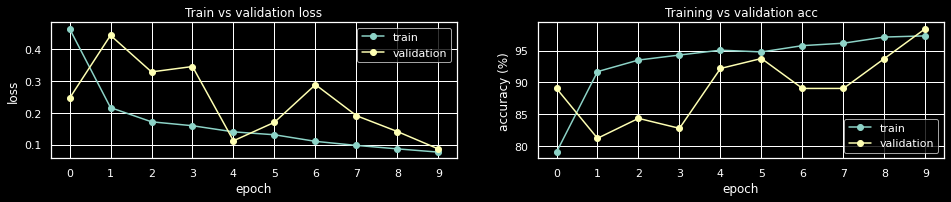

In [24]:
# metrics plot
trainer.metrics.plot()

In [25]:
def infer(model, data_path: str):
    """give trained `model` & `data_path` where images whose 
    labels have to be predicted are kept.
    
    `data_path`: path to data eg. ./test/<random_class>/*.png
    it's important to have a folder with a`random class` name as ImgFolder
    expects it.
    """
    transform = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize(*imagenet_stats)]
    )
    data = datasets.ImageFolder(data_path, transform=transform)
    dataloader = DataLoader(
        data,
        batch_size=4,
    )
    yhats = []
    images = []
    for (imgs, _) in dataloader:
        imgs = imgs.to(device)
        yhat = model(imgs)
        yhat = yhat.max(1)[1]
        yhat = yhat.data.cpu().numpy()
        yhats.extend(yhat)
        images.extend(imgs.data.cpu())
    return images, yhats

infered images with labels


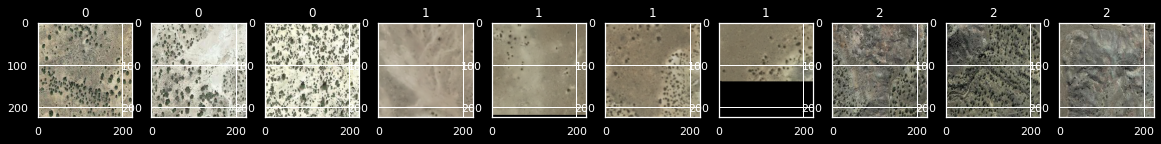

In [26]:

images, yhats = infer(model, data_path="./data/ThreeClassBalanced5000/test/")
infer_dataloader = DataLoader([*zip(images, yhats)], batch_size=100, shuffle=False)
print("infered images with labels")
show_data(infer_dataloader, imagenet_stats, 10, figsize=(20, 8))

fine tuning model for max epochs: 5
Epoch: [1]


ev loop: 100%|██████████| 14/14 [00:11<00:00,  1.21it/s]


loss:
 training set  : 0.4585
 validation set: 0.3395
accuracy:
 training set  : 0.8032
 validation set: 0.8594 
Epoch: [2]


ev loop: 100%|██████████| 14/14 [00:11<00:00,  1.21it/s]


loss:
 training set  : 0.2138
 validation set: 0.6855
accuracy:
 training set  : 0.9165
 validation set: 0.7031 
Epoch: [3]


ev loop: 100%|██████████| 14/14 [00:11<00:00,  1.17it/s]


loss:
 training set  : 0.189
 validation set: 0.1649
accuracy:
 training set  : 0.9303
 validation set: 0.9219 
Epoch: [4]


ev loop: 100%|██████████| 14/14 [00:12<00:00,  1.12it/s]


loss:
 training set  : 0.156
 validation set: 0.2449
accuracy:
 training set  : 0.946
 validation set: 0.875 
Epoch: [5]


ev loop: 100%|██████████| 14/14 [00:11<00:00,  1.21it/s]


loss:
 training set  : 0.1264
 validation set: 0.144
accuracy:
 training set  : 0.958
 validation set: 0.9062 
fine tuning model for max epochs: 5
Epoch: [1]


ev loop: 100%|██████████| 14/14 [00:11<00:00,  1.27it/s]


loss:
 training set  : 0.4465
 validation set: 0.08185
accuracy:
 training set  : 0.8269
 validation set: 0.9844 
Epoch: [2]


ev loop: 100%|██████████| 14/14 [00:11<00:00,  1.26it/s]


loss:
 training set  : 0.221
 validation set: 0.1637
accuracy:
 training set  : 0.9152
 validation set: 0.9531 
Epoch: [3]


ev loop: 100%|██████████| 14/14 [00:11<00:00,  1.22it/s]


loss:
 training set  : 0.1792
 validation set: 0.1353
accuracy:
 training set  : 0.9337
 validation set: 0.9375 
Epoch: [4]


ev loop: 100%|██████████| 14/14 [00:11<00:00,  1.26it/s]


loss:
 training set  : 0.1604
 validation set: 0.07411
accuracy:
 training set  : 0.9427
 validation set: 0.9531 
Epoch: [5]


ev loop: 100%|██████████| 14/14 [00:10<00:00,  1.28it/s]

loss:
 training set  : 0.1368
 validation set: 0.02496
accuracy:
 training set  : 0.9518
 validation set: 1.0 
% difference between time taken by training loop for ipex on vs off:11.59 %


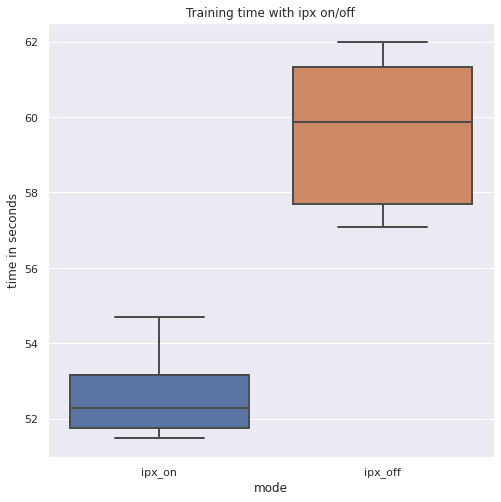

In [27]:
# compare time taken with ipx off vs on


def _create_dataframe(ipx_off, ipx_on):
    stats = pd.DataFrame()
    stats["ipx_on"] = ipx_on
    stats["ipx_off"] = ipx_off
    return stats


def cpu_time_comparision(ipx_off, ipx_on):
    """compare time taken for each epoch with ipx on/off"""
    print(
        f"% difference between time taken by training loop for ipex on vs off:{(np.mean(ipx_off) - np.mean(ipx_on)) / np.mean(ipx_off) * 100:.2f} %"
    )
    try:
        import seaborn as sns
    except ImportError:
        print("seaborn not install to check running time, to see the plot")
    stats = _create_dataframe(ipx_off, ipx_on)
    sns.set(rc={"figure.figsize": (8, 8)})
    p = sns.boxplot(data=stats, linewidth=2)
    p.set_xlabel("mode")
    p.set_ylabel("time in seconds")
    p.set_title("Training time with ipx on/off")


def cpu_train_times(
    backbone=18, train_dataloader=train_dataloader, valid_dataloader=valid_dataloader
):
    """get training time between ipex off and on."""
    if device != "cpu":
        sys.exit("can run this function only for CPUs, set `device=cpu`")
    model1 = DinosourBoneFinder(backbone)
    trainer_ipx_off = Trainer(model1, device, epochs=5, ipx=False)
    train_time_ipx_off = trainer_ipx_off.fine_tune(train_dataloader, valid_dataloader)
    del model1
    model2 = DinosourBoneFinder(backbone)
    trainer_ipx_on = Trainer(model2, device, epochs=5, ipx=True)
    train_time_ipx_on = trainer_ipx_on.fine_tune(train_dataloader, valid_dataloader)
    del model2
    return train_time_ipx_off, train_time_ipx_on


# plot training time for ipx off vs on
cpu_time_comparision(*cpu_train_times())
